In [2]:
import torch
from torch import nn
from IPython.display import clear_output
pt_version = torch.__version__
print(pt_version)

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
1.12.1+cu102


Install dependencies. This is going to take a while.

In [ ]:
!pip install torchmetrics
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-geometric
!pip install torch-geometric-temporal
clear_output()

In [3]:
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal
from torchmetrics.classification import BinaryStatScores


# Dataset

In [4]:
NUM_FEATURES = 31

In [5]:
def get_positional_encoding(pos, dim, w):
    div_term = torch.exp(torch.arange(0, dim, 2) * (-math.log(w) / dim))
    pe = torch.zeros(dim)
    pe[0::2] = torch.sin(pos * div_term)
    pe[1::2] = torch.cos(pos * div_term)
    return pe

In [6]:
class SingleTrackDataset(Dataset):
    def __init__(self, track: int) -> None:
        assert track >= 0 and track < 60

        # Use the csv files from the tgn branch on github because it's cleaned up
        self.all_tracks = pd.read_csv(f'vehicle_tracks_{track:03}.csv', index_col=0)
        self.num_cars = self.all_tracks['track_id'].max() + 1
        all_pairs = pd.read_csv('all_info.csv')

        self.all_pairs = all_pairs.loc[all_pairs['new_i'].isin(self.all_tracks['new_track_id'])]
        self.total_timesteps = self.all_tracks['frame_id'].max() + 1

        # Columns in all_pairs:
        # Instance,i,j,TTC,x_x,y_x,vx_x,vy_x,psi_rad_x,length_x,width_x,
        # psi_deg_x,y_acc_x,x_acc_x,yaw_rate_x,long_acc_x,lat_acc_x,
        # r_long_acc_x,r_lat_acc_x,r_yaw_rate_x,x_y,y_y,vx_y,vy_y,psi_rad_y,
        # length_y,width_y,psi_deg_y,y_acc_y,x_acc_y,yaw_rate_y,long_acc_y,
        # lat_acc_y,r_long_acc_y,r_lat_acc_y,r_yaw_rate_y,file,y,2d ttc,new_i,new_j

        # Columns in all_tracks:
        # 'track_id', 'frame_id', 'timestamp_ms', 'agent_type', 'x', 'y',
        # 'vx', 'vy', 'psi_rad', 'length', 'width', 'psi_deg', 'y_acc', 'x_acc',
        # 'yaw_rate', 'long_acc', 'lat_acc', 'r_long_acc', 'r_lat_acc',
        # 'r_yaw_rate', 'cos', 'sin', 'new_track_id'

    def __len__(self) -> int:
        return self.total_timesteps

    def __getitem__(self, timestep: int) -> tuple[torch.FloatTensor, torch.LongTensor, torch.Tensor]:
        # Node features and edges at this frame_id
        features_snapshot = np.zeros((self.num_cars, NUM_FEATURES))
        edges_snapshot = []
        labels_snapshot = []
        track_ids = []

        # Get node features
        tracks_at_this_frame_id = self.all_tracks[self.all_tracks['frame_id'] == timestep]
        for i in range(tracks_at_this_frame_id.shape[0]):
            row = tracks_at_this_frame_id.iloc[i]
            node = row['track_id']
            track_ids.append(node)

            in_intersection = 1
            x, y = row['x'], row['y']
            vx, vy = row['vx'], row['vy']
            length, width = row['length'], row['width']
            y_acc, x_acc = row['y_acc'], row['x_acc']
            yaw_rate = row['yaw_rate']
            long_acc, lat_acc = row['long_acc'], row['lat_acc']
            r_long_acc, r_lat_acc = row['r_long_acc'], row['r_lat_acc']
            r_yaw_rate = row['r_yaw_rate']
            cos, sin = row['cos'], row['sin']
            node_features = np.concatenate((
                [in_intersection],
                get_positional_encoding(x, 2, 100),
                get_positional_encoding(y, 2, 100),
                get_positional_encoding(vx, 2, 200),
                get_positional_encoding(vy, 2, 200),
                get_positional_encoding(length, 2, 300),
                get_positional_encoding(width, 2, 300),
                get_positional_encoding(y_acc, 2, 400),
                get_positional_encoding(x_acc, 2, 400),
                get_positional_encoding(yaw_rate, 2, 500),
                get_positional_encoding(long_acc, 2, 600),
                get_positional_encoding(lat_acc, 2, 600),
                get_positional_encoding(long_acc, 2, 700),
                get_positional_encoding(lat_acc, 2, 700),
                get_positional_encoding(r_yaw_rate, 2, 800),
                [cos], [sin]
            ))

            features_snapshot[node] = torch.FloatTensor(node_features)

        # Get edges
        pairs_at_this_frame_id = self.all_pairs[self.all_pairs['Instance'] == timestep]
        for i in range(pairs_at_this_frame_id.shape[0]):
            row = pairs_at_this_frame_id.iloc[i]
            node1, node2 = row['i'], row['j']
            edges_snapshot.append([node1, node2])

            # Get edge label
            label = row['y']
            labels_snapshot.append(label)

        features_snapshot = torch.FloatTensor(features_snapshot)
        if edges_snapshot:
            edges_snapshot = torch.t(torch.LongTensor(edges_snapshot))
        else:
            edges_snapshot = torch.LongTensor([[], []])
        labels_snapshot = torch.Tensor(labels_snapshot)

        return features_snapshot, edges_snapshot, labels_snapshot, track_ids

In [7]:
def get_dataset(track: int):
    dataset = SingleTrackDataset(track)
    quarter = int(0.25 * len(dataset))
    set1 = torch.utils.data.Subset(dataset, range(quarter))
    set2 = torch.utils.data.Subset(dataset, range(quarter, quarter*2))
    set3 = torch.utils.data.Subset(dataset, range(quarter*2, quarter*3))
    set4 = torch.utils.data.Subset(dataset, range(quarter*3, quarter*4))
    #test_set = torch.utils.data.Subset(dataset, range(train_size + val_size, len(dataset)))
    return set1, set2, set3, set4

# Model

In [8]:
from torch_geometric_temporal.nn.recurrent import TGCN

class CollisionTGCN(nn.Module):
    def __init__(self, out_features=128):
        super(CollisionTGCN, self).__init__()
        self.tgcn = TGCN(NUM_FEATURES, out_features)
        self.linear = nn.Sequential(
            nn.Linear(2 * out_features, 1),
            nn.Sigmoid()
        )

    def forward(self, x, edge_index, state=None):
        """
        x = Node features for single time step, shape [num_nodes, num_features]
        edge_index = Graph edge indices, shape [2, num_edges]

        Graph topology at time t:   0 ----- 1 ----- 2 ----- 3
        x:          [[node_features],
                     [node_features],
                     [node_features],
                     [node_features]]
        edge_index: [[0, 1, 2],
                     [1, 2, 3]]
        h:          [[out_channels],
                     [out_channels],
                     [out_channels],
                     [out_channels]]
        """
        node_outputs = self.tgcn(x, edge_index, H=state)

        # If there are no edges, there is nothing to predict
        if edge_index.shape[1] == 0:
            return node_outputs, None
        
        # Edge embedding = mean of both node hidden states
        edge_embeddings = []
        for i in range(edge_index.shape[1]):
            node1, node2 = edge_index[0][i], edge_index[1][i]
            combined = torch.cat((node_outputs[node1], node_outputs[node2]), 0)
            edge_embeddings.append(combined[None, :])
        edge_embeddings = torch.cat(edge_embeddings, 0)
        edge_predictions = self.linear(edge_embeddings)

        return node_outputs, edge_predictions

CollisionTGCN()

CollisionTGCN(
  (tgcn): TGCN(
    (conv_z): GCNConv(31, 128)
    (linear_z): Linear(in_features=256, out_features=128, bias=True)
    (conv_r): GCNConv(31, 128)
    (linear_r): Linear(in_features=256, out_features=128, bias=True)
    (conv_h): GCNConv(31, 128)
    (linear_h): Linear(in_features=256, out_features=128, bias=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [9]:
def train(train_set, model, loss_fn, optimizer):
    """
    Train model for given timesteps for a single intersection.
    Returns training loss.
    """

    state = None
    all_pred, all_labels = [], []
    model.train()

    for features, edges, labels, track_ids in tqdm(train_set, desc='Training'):
        features = features.to(device)
        edges = edges.to(device)
        labels = labels.to(device)

        # Compute prediction
        state, pred = model(features, edges, state)
        if pred is not None:
            all_pred.append(pred)
            all_labels.append(labels)

    # Compute loss
    all_pred = torch.cat(all_pred).squeeze()
    all_labels = torch.cat(all_labels).squeeze()
    loss = loss_fn(all_pred, all_labels)
    train_loss = loss.item()

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return train_loss

def validate(val_set, model, loss_fn):
    """
    Evaluate model for given timesteps for a single intersection.
    Returns validation loss.
    """
    state = None
    all_pred, all_labels = [], []
    model.eval()

    with torch.no_grad():
        for features, edges, labels, track_ids in tqdm(val_set, desc='Validating'):
            features = features.to(device)
            edges = edges.to(device)
            labels = labels.to(device)

            # Compute prediction
            state, pred = model(features, edges, state)
            if pred is not None:
                all_pred.append(pred)
                all_labels.append(labels)

        # Compute loss
        all_pred = torch.cat(all_pred).squeeze()
        all_labels = torch.cat(all_labels).squeeze()
        loss = loss_fn(all_pred, all_labels)
        val_loss = loss.item()
        metric = BinaryStatScores()
        accuracy = metric(all_pred, all_labels)

    return val_loss, accuracy

# Training and Testing

In [10]:
device = 'cpu'
print(device)

cpu


In [11]:
# Create model and optimizers
model = CollisionTGCN()
model.to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
train_losses, val_losses = [], []

In [19]:
dataset0 = SingleTrackDataset(0)
dataset1 = SingleTrackDataset(1)
train_set = torch.utils.data.Subset(dataset0, range(1000))
val_set = torch.utils.data.Subset(dataset1, range(1000))

In [ ]:
# THIS IS THE REAL CODE
epochs = np.arange(1, 11)
for epoch in epochs:
    print(f'---------------- Epoch {epoch} ----------------')
    
    train_loss = train(train_set, model, criterion, optimizer)
    print(f'Training loss: {train_loss}')

    val_loss, (true_pos, false_pos, true_neg, false_neg, _) = validate(val_set, model, criterion)
    print(f'Validation loss: {val_loss}')

    if epoch == epochs[-1]:
        accuracy = (true_pos + true_neg) / (true_pos + false_pos + true_neg + false_neg)
        precision = true_pos / (true_pos + false_pos)
        recall = true_pos / (true_pos + false_neg)

        print(f'Accuracy: {accuracy}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')

    train_losses.append(train_loss)
    val_losses.append(val_loss)

In [22]:
import matplotlib.pyplot as plt

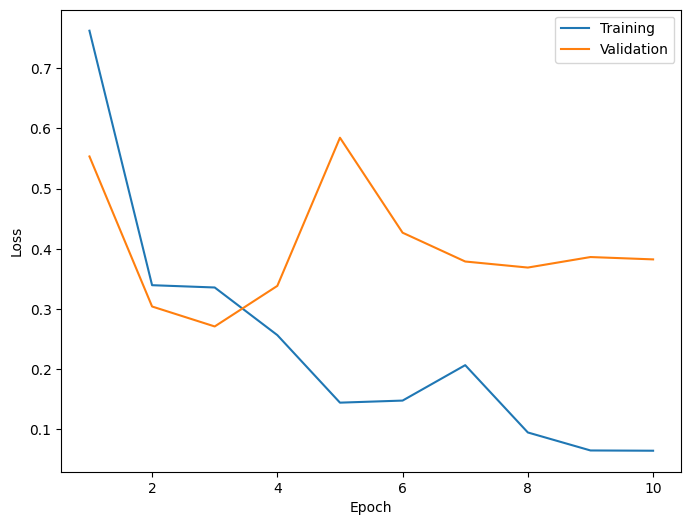

In [28]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label='Training')
plt.plot(epochs, val_losses, label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('losses.png')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8458e01d-cd45-4862-b076-196a36708086' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>